### Notebook 2: Gaussian Process with multi-fidelity learning

In this notebook, we will walk through the process of building a *multi-fidelity Gaussian Process*. This type of model can aggregate training data with different fidelities, therefore optimizing the trade-off between training cost and accuracy. A major motive behind employing multi-fidelity strategies lies in its premise of using the low-fidelity model for quick explorations of the parameter space, while keeping the high-fidelity model in the loop to ensure accuracy

> GPflow depends on both TensorFlow and TensorFlow Probability, which require very specific versions to be compatible. For example:
>
> **`!pip install gpflow tensorflow~=2.10.0 tensorflow-probability~=0.18.0`**
>
> For more details, please refer to the [official documents](https://gpflow.github.io/GPflow/2.9.1/installation.html).

### 0. Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import qmc

import gpflow
import tensorflow as tf
from GPflow_wrapper import GPflowWrapper

### 1. Problem Setup

In this tutorial, we aim to approximate the following function, which we assume is a high-fidelity function:

\begin{equation}
y(x) = (6x-2)^2sin(12x-4), \; x \in [0, 1]
\end{equation}

In addition to the training data directly generated from the above function, we also have some training data generated from a low-fidelity approximation of the above function: 

\begin{equation}
y(x) = 0.5(6x-2)^2sin(12x-4)+10(x-0.5)-5, \; x \in [0, 1]
\end{equation}

Later on, we will train a multi-fidelity GP model to aggregate training data from both fidelities and the resulting GP model can accurately approximate the high-fidelity function. 

In [2]:
def HF_function(x):
    y = (6*x-2)**2*np.sin(12*x-4)
    return y

def LF_function(x):
    y = 0.5*(6*x-2)**2*np.sin(12*x-4) + 10*(x-0.5) - 5
    return y

#### 1.1 Generate train/test dataset

For the current multi-fidelity modeling task, we sample the design space extensively using the low-fidelity function, but only run the high-fidelity function at several of these points.

In [3]:
# Low-fidelity training dataset
X_train_LF = np.linspace(0, 1, 11).reshape(-1,1)
y_train_LF = LF_function(X_train_LF)

# High-fidelity training dataset
X_train_HF = np.array([0, 0.4, 0.6, 1]).reshape(-1,1)
y_train_HF = HF_function(X_train_HF)

# Test data
X_test = np.linspace(0, 1, 100).reshape(-1,1)
y_test = HF_function(X_test)

#### 1.2 Visualization

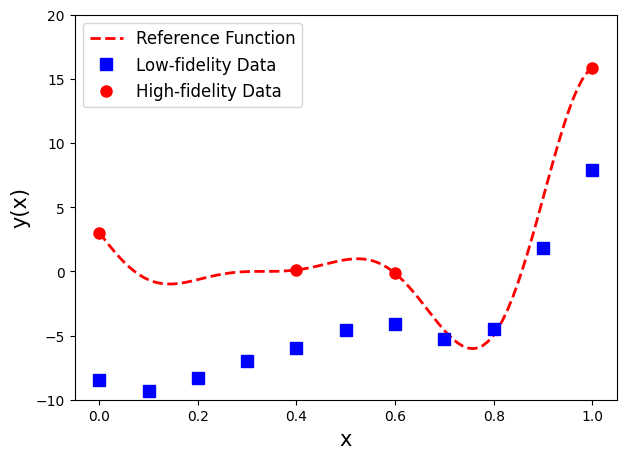

In [4]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test, y_test,'r--', lw=2, label='Reference Function')
ax.plot(X_train_LF, y_train_LF, 'bs', markerfacecolor='b', 
        markersize=8, label='Low-fidelity Data')
ax.plot(X_train_HF, y_train_HF, 'ro', markerfacecolor='r', 
        markersize=8, label='High-fidelity Data')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y(x)', fontsize=15)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-10, 20])
ax.legend(loc="upper left",prop={'size': 12});

As we can see from the above figure, the low-fidelity data only qualitatively captures the trend of the reference function. In the following, we will see that by augmenting a few high-fidelity training data with extensive low-fidelity data, we are able to approximate the reference function accurately.

### 2. GP model using only high-fidelity data

First of all, let's see the accuracy of the GP model trained with high-fidelity data only.

In [ ]:
# Init GP model
GP_model = GPflowWrapper()

# Model training
GP_model.fit(X_train_HF, y_train_HF)

In [ ]:
# Model performance assessment
HF_pred, _ = GP_model.predict(X_test, full_cov=False)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(X_test, y_test,'r--', lw=2, label='Reference Function')
ax.plot(X_test.flatten(), HF_pred,'k--', lw=2, label='GP predictions')
ax.plot(X_train_HF, y_train_HF, 'ro', markerfacecolor='r', 
        markersize=8, label='High-fidelity Data')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y(x)', fontsize=15)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-10, 20])
ax.legend(loc="upper left", prop={'size': 10});

Obviously, the amount of training data is not enough. Next, we augment the high-fidelity training data with the low-fidelity data and see how multi-fidelity GP model performs.

### 3. Multi-fidelity GP model

#### 3.1 Training low-fidelity GP model

The first step in multi-fidelity modeling framework is to train a GP model based on low-fidelity training data.

In [5]:
# Init GP model for low-fidelity sample training
GP_LF = GPflowWrapper()

# Model training
GP_LF.fit(X_train_LF, y_train_LF)

Performing 1-th optimization:
Log likelihood: -32.944737092902415
Performing 2-th optimization:
Log likelihood: -20.487516020202598
Performing 3-th optimization:
Log likelihood: -20.487516020216397
Performing 4-th optimization:
Log likelihood: -20.48745873767055
Performing 5-th optimization:
Log likelihood: -32.944737306629214
Best model log-marginal likelihood: -20.48745873767055


#### 3.2 Training multi-fidelity GP model

Next, we train a multi-fidelity GP model. We start by defining a custom mean function.

In [6]:
class ScaledCustom(gpflow.functions.MeanFunction):
    def __init__(self, LF_model, scaler=1):
        self.LF_model = LF_model
        self.scaler = gpflow.Parameter(scaler, trainable=True)
        
    def __call__(self, X: gpflow.base.TensorType) -> tf.Tensor:
        f_mean, _ = self.LF_model.GP.predict_f(X, full_cov=False)
        return self.scaler*f_mean

We then set up the training pipeline

In [ ]:
# We sample in the log-space
n_restarts = 10
lb, ub = -2, 2
lhd = qmc.LatinHypercube(d=X_train_HF.shape[1], seed=42).random(n_restarts)
length_scales = (ub-lb)*lhd + lb
length_scales = 10**length_scales

In [ ]:
# Configure the GP training procedure
models = []
log_likelihoods = []

with tf.device("CPU:0"):

    for i, length_scale in enumerate(length_scales):
        print(f"Performing {i+1}-th optimization:")

        # Init model
        kernel = gpflow.kernels.SquaredExponential(variance=np.var(y_train_HF), lengthscales=length_scale)
        model = gpflow.models.GPR(
            (X_train_HF, y_train_HF.reshape(-1, 1)),
            kernel=kernel,
            mean_function=ScaledCustom(LF_model=GP_LF)
        )

        # Training
        opt = gpflow.optimizers.Scipy()
        opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))

        # Record keeping
        models.append(model)
        log_likelihoods.append(model.log_marginal_likelihood().numpy())
        print(f"Log likelihood: {log_likelihoods[-1]}")

# Select the model with the highest log-marginal likelihood
best_model_index = np.argmax(log_likelihoods)
best_model = models[best_model_index]

print(f"Best model log-marginal likelihood: {log_likelihoods[best_model_index]}")

#### 3.3 Performance assessment

First, we display the summary of the trained GP model.

In [ ]:
gpflow.utilities.print_summary(best_model)

Next, we assess the accuracy of the trained GP model.

In [ ]:
# GP model predicting
f_mean, f_var = best_model.predict_f(X_test, full_cov=False)
f_mean = f_mean.numpy().flatten()
f_var = f_var.numpy().flatten()

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test, y_test,'r--', lw=2, label='Reference Function')
ax.plot(X_test, f_mean,'k--', lw=2, label='Multi-fidelity GP')
ax.plot(X_train_LF, y_train_LF, 'bs', markerfacecolor='b', 
        markersize=8, label='Low-fidelity Data')
ax.plot(X_train_HF, y_train_HF, 'ro', markerfacecolor='r', 
        markersize=8, label='High-fidelity Data')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y(x)', fontsize=15)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-10, 20])
ax.legend(loc="upper left",prop={'size': 12});

### 4. GPflow class update

Now, we call the wrapper class to perform multi-fidelity GP training & inference.

In [7]:
mean_func_dict = {
    "type": "multi-fidelity",
    "value": ScaledCustom(LF_model=GP_LF)
}

# Multi-fidelity learning: informed low-fidelity function
GP_HF = GPflowWrapper(mean_func=mean_func_dict)
GP_HF.fit(X_train_HF, y_train_HF)

Performing 1-th optimization:
Log likelihood: -13.5656044627856
Performing 2-th optimization:
Log likelihood: -4.391059411805781
Performing 3-th optimization:
Log likelihood: -11.818337769866284
Performing 4-th optimization:
Log likelihood: -4.330632791958109
Performing 5-th optimization:
Log likelihood: -11.81836236504616
Best model log-marginal likelihood: -4.330632791958109


In [8]:
# GP model predicting
MF_pred, _ = GP_HF.predict(X_test, full_cov=False)

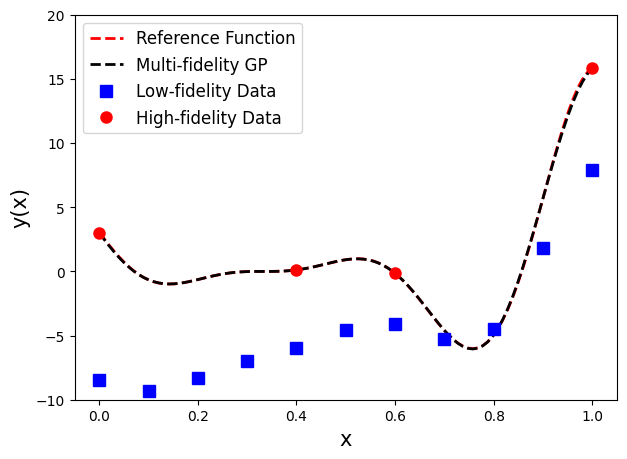

In [9]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test, y_test,'r--', lw=2, label='Reference Function')
ax.plot(X_test, MF_pred,'k--', lw=2, label='Multi-fidelity GP')
ax.plot(X_train_LF, y_train_LF, 'bs', markerfacecolor='b', 
        markersize=8, label='Low-fidelity Data')
ax.plot(X_train_HF, y_train_HF, 'ro', markerfacecolor='r', 
        markersize=8, label='High-fidelity Data')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y(x)', fontsize=15)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-10, 20])
ax.legend(loc="upper left",prop={'size': 12});